# Part 5: PCA and Modelling

In this notebook, I will bring in the data and performing modelling. Specifically, I will perform dimensionality reduction via PCA and subsequently, KMeans Clustering.

Here are the steps to be undertaken:
1. Perform Tokenization
2. Scale numeric features
3. Perform PCA
4. Run several models and optimize hyperparameters
5. Choose optimal model for KMeans

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#import custom functions
import functions_library as fl

In [3]:
#let's bring in the beauty review dataset with the cleaning and feature engineering steps applied
df = fl.pipedf('All_Beauty.json.gz')

### 1. Perform Tokenization

- For reviewText, will use: lemmatizer, ngrams 1-2, **min_df = 1000**
- For summary, will use: lemmatizer, ngrams 1-2, **min_df = 800**

In [4]:
#getting review tokens which will be prepended with 'r_'
review_tokens = fl.tfidf(df['reviewText'], tokenizer=fl.spl_tokenizer, ngram_range=(1,2), min_df=1000)

In [5]:
#getting summary tokens which will be prepended with 's_'
summary_tokens = fl.tfidf(df['summary'], tokenizer=fl.spl_tokenizer, ngram_range=(1,2), min_df=800)

### 2. Scale numeric features
Will be using the MinMaxScaler to scale the non-token features.

In [6]:
#getting the numeric features (no tokens)
df2=df.select_dtypes(include=['int32','int64'])

In [7]:
from sklearn.preprocessing import MinMaxScaler

In [8]:
#instantiate minmaxscaler
mm = MinMaxScaler()

In [9]:
#fit transform data using minmaxscaler
df3 = mm.fit_transform(df2)

In [10]:
#put the scaled into a dataframe
df_scaled = pd.DataFrame(df3, columns = df2.columns)

In [13]:
df_scaled.shape

(362252, 12)

In [11]:
#saving memory
del df3, df2

#### Now let's bring in the tokens to get the final dataframe.

In [12]:
#concatenating the scaled non-token features and the review & summary tokens
df_final = pd.concat([df_scaled, review_tokens, summary_tokens], axis = 1)

In [25]:
#save data
df_final.to_csv('all_tokens_scaled.zip', compression='zip')

In [17]:
df_final.tail()

,overall,verified,vote,review_word_count,summary_word_count,month,dayofweek,multipleReviews_reviewer,reviewer_five_star_only,reviewer_one_star_only,...,s_well,s_without,s_wonderful,s_work,s_work s_great,s_work s_well,s_worked,s_worth,s_would,s_year
362247,0.00,1.0,0.000000,0.011057,0.087248,0.545455,0.500000,0.0,0.0,1.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362248,1.00,1.0,0.012495,0.017199,0.006711,0.181818,0.500000,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362249,1.00,1.0,0.016906,0.001638,0.013423,0.181818,0.333333,0.0,1.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362250,0.25,1.0,0.000000,0.011057,0.060403,0.090909,0.166667,0.0,0.0,0.0,...,0.457313,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
362251,0.25,1.0,0.000000,0.012695,0.053691,1.000000,0.500000,1.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#saving memory
del review_tokens, summary_tokens, df_scaled, df

### 3. Perform PCA
As we have seen above, the final dataframe contains 1347 features so this dataset is a good candidate for dimensionality reduction. Will do so using PCA.

In [14]:
#import PCA
from sklearn.decomposition import PCA

In [15]:
# Create a PCA instance: pca
pca = PCA(n_components=500)
pcs = pca.fit_transform(df_final)

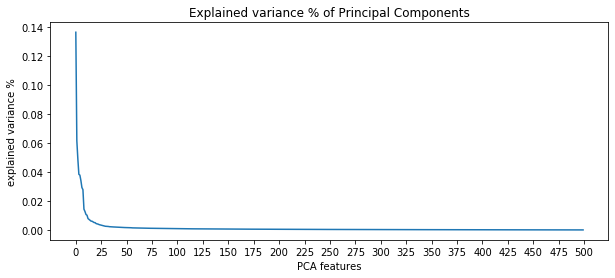

In [22]:
# Plot the explained variances
plt.figure(figsize=(10,4))
plt.plot(range(500), pca.explained_variance_ratio_[0:500])
plt.xlabel('PCA features')
plt.ylabel('explained variance %')
plt.xticks(range(0,501,25))
plt.title('Explained variance % of Principal Components')
plt.show()

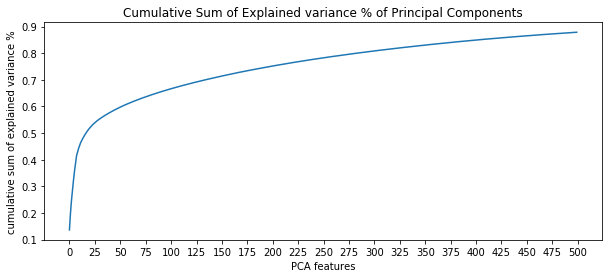

In [23]:
# Plot the cumulative sum of explained variances
plt.figure(figsize=(10,4))
plt.plot(range(500), pca.explained_variance_ratio_.cumsum()[0:500])
plt.xlabel('PCA features')
plt.ylabel('cumulative sum of explained variance %')
plt.xticks(range(0,501,25))
plt.title('Cumulative Sum of Explained variance % of Principal Components')
plt.show()

From the above, we want to have as much explained variance as possible from the least number of principal components. As a rough guide, I want to be able to have at least 80% explained variance.

In [34]:
#explained variance for 300 PCs
pca.explained_variance_ratio_.cumsum()[300]

0.8084291480511138

In [30]:
#explained variance for 350 PCs
pca.explained_variance_ratio_.cumsum()[350]

0.8304192116429999

In [35]:
#explained variance for 300 PCs
pca.explained_variance_ratio_.cumsum()[400]

0.8493394370547046

300 PCs provides 80% explained variance. 400 PCs gets close to 85%. For later modelling, let's try using **350 PCs** as we get a decent tradeoff: 50 more features for 2.2% increase in explained variance compared to 300 PCs. I note that this may not provide the optimal settings to build a model but the model can always be improved in later iterations of this project.

In [18]:
# Save components to a DataFrame
PCA_components = pd.DataFrame(pcs)

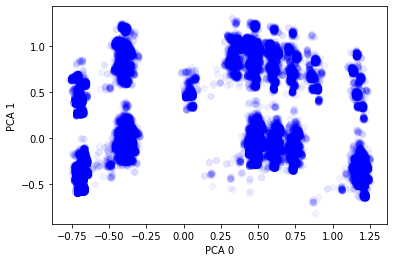

In [37]:
#this is what the first two features look like (plot)
plt.figure()
plt.scatter(PCA_components[0],PCA_components[1], alpha=.05, color='blue')
plt.xlabel('PCA 0')
plt.ylabel('PCA 1')
plt.show()

## KMeans Clustering
The moment we have been waiting for. We can now begin building our model. For this project I would like to try using Kmeans clustering. Additionally, I will try using LDA topic modelling, which will be performed in a separate notebook.

In [16]:
from sklearn.cluster import KMeans

In [44]:
#we begin by trying to determine the optimal number of clusters by looking at inertia scores
#cycle through different K values and append inertia score to list
k_values = range(8,32)
inertia_scores = []

for k in k_values:
    #instantiate
    kmeans_model = KMeans(n_clusters=k, n_jobs=5, verbose=1)
    #fitting on first 350 PCs
    kmeans_model.fit(PCA_components.iloc[:,0:350])
    #get scores and append them
    inertia = kmeans_model.inertia_
    #append score
    inertia_scores.append(inertia)

Wall time: 15min 58s


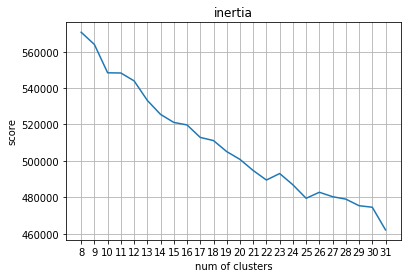

In [48]:
plt.figure()
plt.plot(k_values, inertia_scores)
plt.xlabel('num of clusters')
plt.ylabel('score')
plt.title('inertia')
plt.xticks(k_values)
plt.grid()
#plt.ylim(0,580000)
plt.show()

Based on the graph, there is a decrease in the slope at the following number of clusters: 15, 17, 25.

# View Cluster Features
For Kmeans, the optimal number of clusters are **15, 17, and 25.** As 25 has the lowest inertia, let's try using 25 clusters.

### 25 clusters

In [19]:
#instantiate KMeans with 25 clusters
kmeans_model25 = KMeans(n_clusters=25, n_jobs=5, verbose=1)
#fitting KMeans on first 350 PCs
kmeans_model25.fit(PCA_components.iloc[:,0:350])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=25, n_init=10, n_jobs=5, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=1)

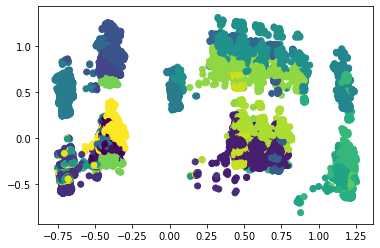

In [41]:
#let's take a look at the first 2 PCs with the labels generated from KMeans
plt.figure()
plt.scatter(PCA_components[0],PCA_components[1], c=kmeans_model25.labels_)
plt.show()

The are some vague clusters that can be seen from the first 2 PC but quite evidently they are not interpretable at this point.

Let's save the model in order to perform cluster analysis (in the next notebook). Note, I will also perform LDA topic modelling in parallel and compare the results of each model to try and find a cluster(s) of fake reviews.

In [22]:
import joblib

In [23]:
#saving model to computer to be used for later analysis
joblib.dump(kmeans_model25, 'kmeans_model25.pkl')

['kmeans_model25.pkl']

##### Saving data
We can also save the dataframe with the cluster labels. We will need to perform matrix multiplication to convert the reviews from principal components back to the original features.

In [80]:
#getting 2 matrices
# 1) data with principal components (PCs)
# 2) PCs and features
# only getting 350 PCs as those the model was fit only on those PCs
data_pc_matrix = PCA_components.iloc[:,0:350].to_numpy()
pc_feature_matrix = pca.components_[0:350,:]

In [84]:
#performing matrix multiplication to get the reviews back in terms of the original features; will then save this reconstructed data to a dataframe
df_recon = pd.DataFrame(np.matmul(data_pc_matrix,pc_feature_matrix), columns=df_final.columns)

In [86]:
#adding cluster labels to the reconstructed dataframe
df_recon['cluster'] = kmeans_model25.labels_

In [123]:
#saving the df to the computer in a compressed h5 format (saves faster than other compression techniques)
df_recon.to_hdf('df_recon_25_kmeans.h5', key='df', mode='w')